In [16]:
import math
import multiprocessing
import os
import random
import time
from enum import Enum

import numpy as np
from PIL import Image
import habitat_sim
import habitat_sim.agent
import habitat_sim.bindings as hsim
from habitat_sim.physics import MotionType
from habitat_sim.utils.common import (
    d3_40_colors_rgb,
    download_and_unzip,
    quat_from_angle_axis,
)
from habitat_sim.utils.settings import default_sim_settings
from habitat_sim.utils.settings import make_cfg

import git

In [17]:
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
os.chdir(dir_path)
os.getcwd()

'/data/reventh/habitat-lab'

In [18]:
example_settings = {
    "max_frames": 1000,
    "save_png": False,  # save the pngs to disk (default: OFF)
    "print_semantic_scene": False,
    "print_semantic_mask_stats": False,
    "compute_shortest_path": False,
    "compute_action_shortest_path": False,
    "scene": "data/scene_datasets/habitat-test-scenes/skokloster-castle.glb",
    "test_scene_data_url": "http://dl.fbaipublicfiles.com/habitat/habitat-test-scenes.zip",
    "goal_position": [5.047, 0.199, 11.145],
    "enable_physics": False,
    "enable_gfx_replay_save": False,
    "num_objects": 10,
    "test_object_index": 0,
    "frustum_culling": True,
    "silent": False,  # do not print log info (default: OFF)
}
settings = example_settings
settings["width"] = 640
settings["height"] = 480
settings["save_png"] = True
settings["sensor_height"] = 1.5
settings["color_sensor"] = True
settings["semantic_sensor"] = False
settings["depth_sensor"] = True
settings["print_semantic_scene"] = False
settings["print_semantic_mask_stats"] = False
settings["compute_shortest_path"] = True
settings["compute_action_shortest_path"] = True
settings["seed"] = 1
settings["silent"] = False
settings["enable_physics"] = True
settings["physics_config_file"] = 'data/default.physics_config.json'
settings["frustum_culling"] = True
settings["recompute_navmesh"] = True
_sim_settings = settings
default_sim_settings.update(_sim_settings)
_sim_settings = default_sim_settings


In [19]:
demotype = 2
def save_color_observation(self, obs, total_frames):
    color_obs = obs["color_sensor"]
    color_img = Image.fromarray(color_obs, mode="RGBA")
    color_img.save("test.rgba.%05d.png" % total_frames)

In [20]:
_cfg = make_cfg(default_sim_settings)
sim_cfg = _cfg.sim_cfg
agent_cfg = _cfg.agents[0]
scene_file = _sim_settings["scene"]
if sim_cfg.enable_physics:
    agent_cfg.action_space = {
        "move_forward": habitat_sim.agent.ActionSpec(
            "move_forward", habitat_sim.agent.ActuationSpec(amount=0.0)
        )
    }

In [21]:
import habitat_sim.utils.datasets_download as data_downloader

if (
    not os.path.exists(scene_file)
    and scene_file == default_sim_settings["scene"]
):
    print(
        "Test scenes not downloaded locally, downloading and extracting now..."
    )
    data_downloader.main(["--uids", "habitat_test_scenes"])
    print("Downloaded and extracted test scenes data.")

# create a simulator (Simulator python class object, not the backend simulator)
_sim = habitat_sim.Simulator(_cfg)

random.seed(_sim_settings["seed"])
_sim.seed(_sim_settings["seed"])

recompute_navmesh = _sim_settings.get("recompute_navmesh")
if recompute_navmesh or not _sim.pathfinder.is_loaded:
    if not _sim_settings["silent"]:
        print("Recomputing navmesh")
    navmesh_settings = habitat_sim.NavMeshSettings()
    navmesh_settings.set_defaults()
    _sim.recompute_navmesh(_sim.pathfinder, navmesh_settings)
    agent = _sim.initialize_agent(_sim_settings["default_agent"])
    start_state = agent.get_state()
    num_start_tries = 0
    while start_state.position[1] > 0.5 and num_start_tries < 100:
        start_state.position = _sim.pathfinder.get_random_navigable_point()
        num_start_tries += 1
    agent.set_state(start_state)

    if not _sim_settings["silent"]:
        print(
            "start_state.position\t",
            start_state.position,
            "start_state.rotation\t",
            start_state.rotation,
        )

Recomputing navmesh
start_state.position	 [ 0.82159454  0.17731762 16.00334   ] start_state.rotation	 quaternion(1, 0, 2.45858027483337e-05, 0)


[06:49:20:986717]:[Error]:[Scene] SemanticScene.cpp(137)::loadSemanticSceneDescriptor : SSD Load Failure! File with SemanticAttributes-provided name `data/scene_datasets/habitat-test-scenes/skokloster-castle.scn` exists but failed to load.


In [22]:
action_names = list(
            _cfg.agents[_sim_settings["default_agent"]].action_space.keys()
        )
print(action_names)

['move_forward']


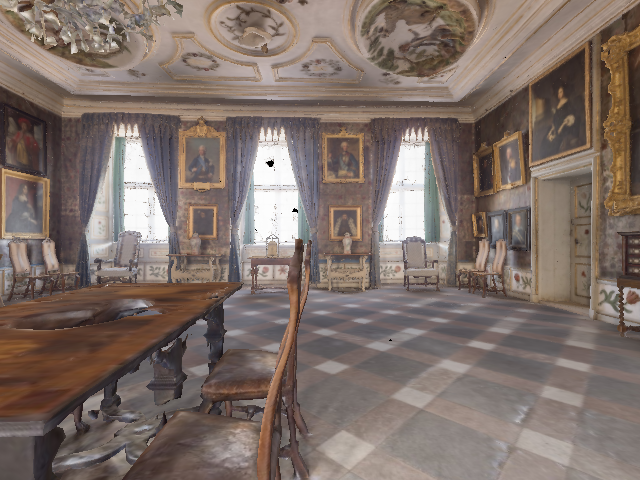

In [23]:
obs = _sim.step(action_names[0])
colorobs = obs["color_sensor"]
Image.fromarray(colorobs, mode="RGBA")

In [9]:
object_position = np.array(
            [-0.569043, 2.04804, 13.6156]
        ) 
obj_template_mgr = _sim.get_object_template_manager()


In [10]:
rigid_obj_mgr = _sim.get_rigid_object_manager()

In [11]:
num_objects = 10

In [12]:
_sim_settings.get("test_object_index")

0

In [13]:
object_lib_size = obj_template_mgr.get_num_templates()
object_init_grid_dim = (3, 1, 3)
object_init_grid = {}
assert (
    object_lib_size > 0
), "!!!No objects loaded in library, aborting object instancing example!!!"

# clear the objects if we are re-running this initializer
rigid_obj_mgr.remove_all_objects()

for _obj_id in range(num_objects):
    # rand_obj_index = random.randint(0, object_lib_size - 1)
    # rand_obj_index = 0  # overwrite for specific object only
    rand_obj_index = _sim_settings.get("test_object_index")
    if rand_obj_index < 0:  # get random object on -1
        rand_obj_index = random.randint(0, object_lib_size - 1)
    object_init_cell = (
        random.randint(-object_init_grid_dim[0], object_init_grid_dim[0]),
        random.randint(-object_init_grid_dim[1], object_init_grid_dim[1]),
        random.randint(-object_init_grid_dim[2], object_init_grid_dim[2]),
    )
    while object_init_cell in object_init_grid:
        object_init_cell = (
            random.randint(-object_init_grid_dim[0], object_init_grid_dim[0]),
            random.randint(-object_init_grid_dim[1], object_init_grid_dim[1]),
            random.randint(-object_init_grid_dim[2], object_init_grid_dim[2]),
        )
    obj = rigid_obj_mgr.add_object_by_template_id(rand_obj_index)
    object_init_grid[object_init_cell] = obj.object_id
    max_union_bb_dim = np.array([0.125, 0.19, 0.26])
    object_offset = np.array(
        [
            max_union_bb_dim[0] * object_init_cell[0],
            max_union_bb_dim[1] * object_init_cell[1],
            max_union_bb_dim[2] * object_init_cell[2],
        ]
    )
    obj.translation = object_position + object_offset
    print(
        "added object: "
        + str(obj.object_id)
        + " of type "
        + str(rand_obj_index)
        + " at: "
        + str(object_position + object_offset)
        + " | "
        + str(object_init_cell)
    )

added object: 1 of type 0 at: [-0.819043  2.23804  14.3956  ] | (-2, 1, 3)
added object: 2 of type 0 at: [-0.194043  1.85804  13.3556  ] | (3, -1, -1)
added object: 3 of type 0 at: [-0.944043  2.04804  14.3956  ] | (-3, 0, 3)
added object: 4 of type 0 at: [-0.569043  2.04804  14.1356  ] | (0, 0, 2)
added object: 5 of type 0 at: [-0.569043  1.85804  12.8356  ] | (0, -1, -3)
added object: 6 of type 0 at: [-0.569043  1.85804  14.3956  ] | (0, -1, 3)
added object: 7 of type 0 at: [-0.569043  2.04804  13.8756  ] | (0, 0, 1)
added object: 8 of type 0 at: [-0.194043  1.85804  14.1356  ] | (3, -1, 2)
added object: 9 of type 0 at: [-0.194043  1.85804  13.8756  ] | (3, -1, 1)
added object: 10 of type 0 at: [-0.944043  2.04804  12.8356  ] | (-3, 0, -3)


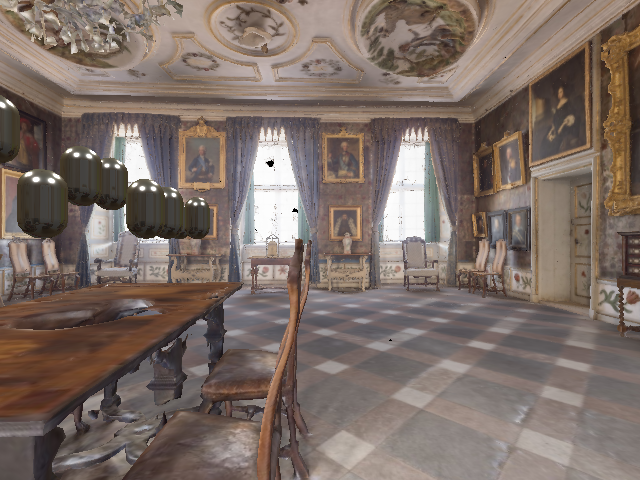

In [14]:
Image.fromarray(_sim.get_sensor_observations()['color_sensor'], mode="RGBA")

In [15]:
_sim.get_sensor_observations()['color_sensor']

array([[[181, 169, 151, 255],
        [177, 165, 148, 255],
        [175, 162, 146, 255],
        ...,
        [141, 113,  86, 255],
        [161, 134, 114, 255],
        [162, 138, 122, 255]],

       [[182, 172, 155, 255],
        [185, 173, 156, 255],
        [182, 170, 154, 255],
        ...,
        [166, 141, 121, 255],
        [166, 142, 128, 255],
        [157, 134, 122, 255]],

       [[177, 168, 152, 255],
        [180, 170, 154, 255],
        [188, 176, 160, 255],
        ...,
        [163, 141, 128, 255],
        [146, 125, 112, 255],
        [117,  94,  83, 255]],

       ...,

       [[ 85,  77,  74, 255],
        [ 85,  77,  74, 255],
        [ 86,  78,  75, 255],
        ...,
        [147, 134, 128, 255],
        [149, 136, 130, 255],
        [148, 135, 129, 255]],

       [[ 84,  76,  73, 255],
        [ 85,  77,  74, 255],
        [ 85,  77,  74, 255],
        ...,
        [146, 134, 128, 255],
        [147, 135, 129, 255],
        [150, 137, 131, 255]],

       [[ 84

In [1]:
import habitat

/opt/conda/envs/habitat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
